In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
DATA = Path("../../data")

In [4]:
train_data = pd.read_csv(DATA / "train_missing_value_80per_under.csv")
test_data = pd.read_csv(DATA / "test_missing_value_80per_under.csv")

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 17 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   stem-height           float64
 2   stem-width            float64
 3   season                object 
 4   cap-diameter          float64
 5   does-bruise-or-bleed  object 
 6   cap-color             object 
 7   has-ring              object 
 8   stem-color            object 
 9   cap-shape             object 
 10  habitat               object 
 11  gill-color            object 
 12  ring-type             object 
 13  gill-attachment       object 
 14  cap-surface           object 
 15  gill-spacing          object 
 16  stem-surface          object 
dtypes: float64(3), object(14)
memory usage: 404.3+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   stem-height           float64
 1   stem-width            float64
 2   season                object 
 3   cap-diameter          float64
 4   does-bruise-or-bleed  object 
 5   cap-color             object 
 6   has-ring              object 
 7   stem-color            object 
 8   cap-shape             object 
 9   habitat               object 
 10  gill-color            object 
 11  ring-type             object 
 12  gill-attachment       object 
 13  cap-surface           object 
 14  gill-spacing          object 
 15  stem-surface          object 
dtypes: float64(3), object(13)
memory usage: 253.7+ MB


In [7]:
train_data

,class,stem-height,stem-width,season,cap-diameter,does-bruise-or-bleed,cap-color,has-ring,stem-color,cap-shape,habitat,gill-color,ring-type,gill-attachment,cap-surface,gill-spacing,stem-surface
0,e,4.51,15.39,a,8.80,f,u,f,w,f,d,w,f,a,s,c,NaN
1,p,4.79,6.48,w,4.51,f,o,t,o,x,d,n,z,a,h,c,y
2,e,6.85,9.93,w,6.94,f,b,f,n,f,l,w,f,x,s,c,s
3,e,4.16,6.53,u,3.88,f,g,f,w,f,d,g,f,s,y,NaN,NaN
4,e,3.37,8.36,a,5.85,f,w,f,w,x,g,w,f,d,l,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,12.14,18.81,u,9.29,t,n,t,w,f,d,w,g,NaN,NaN,NaN,NaN
3116941,e,6.65,26.97,u,10.88,t,w,f,w,s,d,p,f,d,NaN,c,NaN
3116942,p,9.51,11.06,a,7.82,f,e,t,y,x,d,w,z,a,e,NaN,NaN
3116943,e,9.13,17.77,u,9.45,t,n,t,w,p,d,p,p,e,i,NaN,y


In [8]:
test_data

,stem-height,stem-width,season,cap-diameter,does-bruise-or-bleed,cap-color,has-ring,stem-color,cap-shape,habitat,gill-color,ring-type,gill-attachment,cap-surface,gill-spacing,stem-surface
0,11.13,17.12,a,8.64,t,n,t,w,x,d,w,g,NaN,NaN,NaN,NaN
1,1.27,10.75,a,6.90,f,o,f,n,o,d,y,f,NaN,t,c,NaN
2,6.18,3.14,s,2.00,f,n,f,n,b,d,n,f,NaN,g,c,NaN
3,4.98,8.51,u,3.47,f,n,t,w,x,d,n,z,s,t,c,NaN
4,6.73,13.70,u,6.17,f,y,t,y,x,d,y,NaN,p,h,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,2.67,1.35,u,0.88,f,w,f,e,x,d,w,f,a,g,d,NaN
2077960,2.69,7.38,a,3.12,f,w,f,w,x,g,w,f,d,s,c,NaN
2077961,6.16,9.74,a,5.73,f,e,t,y,x,d,w,z,a,e,NaN,NaN
2077962,6.00,3.46,a,5.03,f,n,f,g,b,d,g,f,a,g,d,s


## Numerical

In [9]:
numerical = train_data.select_dtypes(include=["float"]).columns
numerical

Index(['stem-height', 'stem-width', 'cap-diameter'], dtype='object')

In [10]:
# IQR 방법으로 아웃라이어 처리

def outlier_remove_iqr(data, column,threshold=1.5):
    
    # Class가 e인 경우
    q1_e = data.loc[data["class"]=='e', column].quantile(0.25)
    q3_e = data.loc[data["class"]=='e', column].quantile(0.75)
    iqr_e = q3_e-q1_e
    
    lower_e = q1_e - (threshold * iqr_e)
    upper_e = q3_e + (threshold * iqr_e)
    
    data.loc[(data[column] > upper_e) | (data[column] < lower_e) & (data['class']=='e'), column] = np.nan
    
    # Class가 p인 경우
    
    q1_p = data.loc[data["class"]=='p', column].quantile(0.25)
    q3_p = data.loc[data["class"]=='p', column].quantile(0.75)
    iqr_p = q3_p - q1_p
    
    lower_p = q1_p - (threshold * iqr_p)
    upper_p = q3_p + (threshold * iqr_p)
    
    data.loc[(data[column] > upper_p) | (data[column] < lower_p) & (data['class']=='p'), column] = np.nan
    
    return data[column]

In [11]:
train_data["cap-diameter"] = outlier_remove_iqr(data=train_data, column="cap-diameter")
train_data["stem-width"] = outlier_remove_iqr(data=train_data, column="stem-width")
train_data["stem-height"] = outlier_remove_iqr(data=train_data, column="stem-height")

Text(0.5, 1.0, 'Cap-diameter')

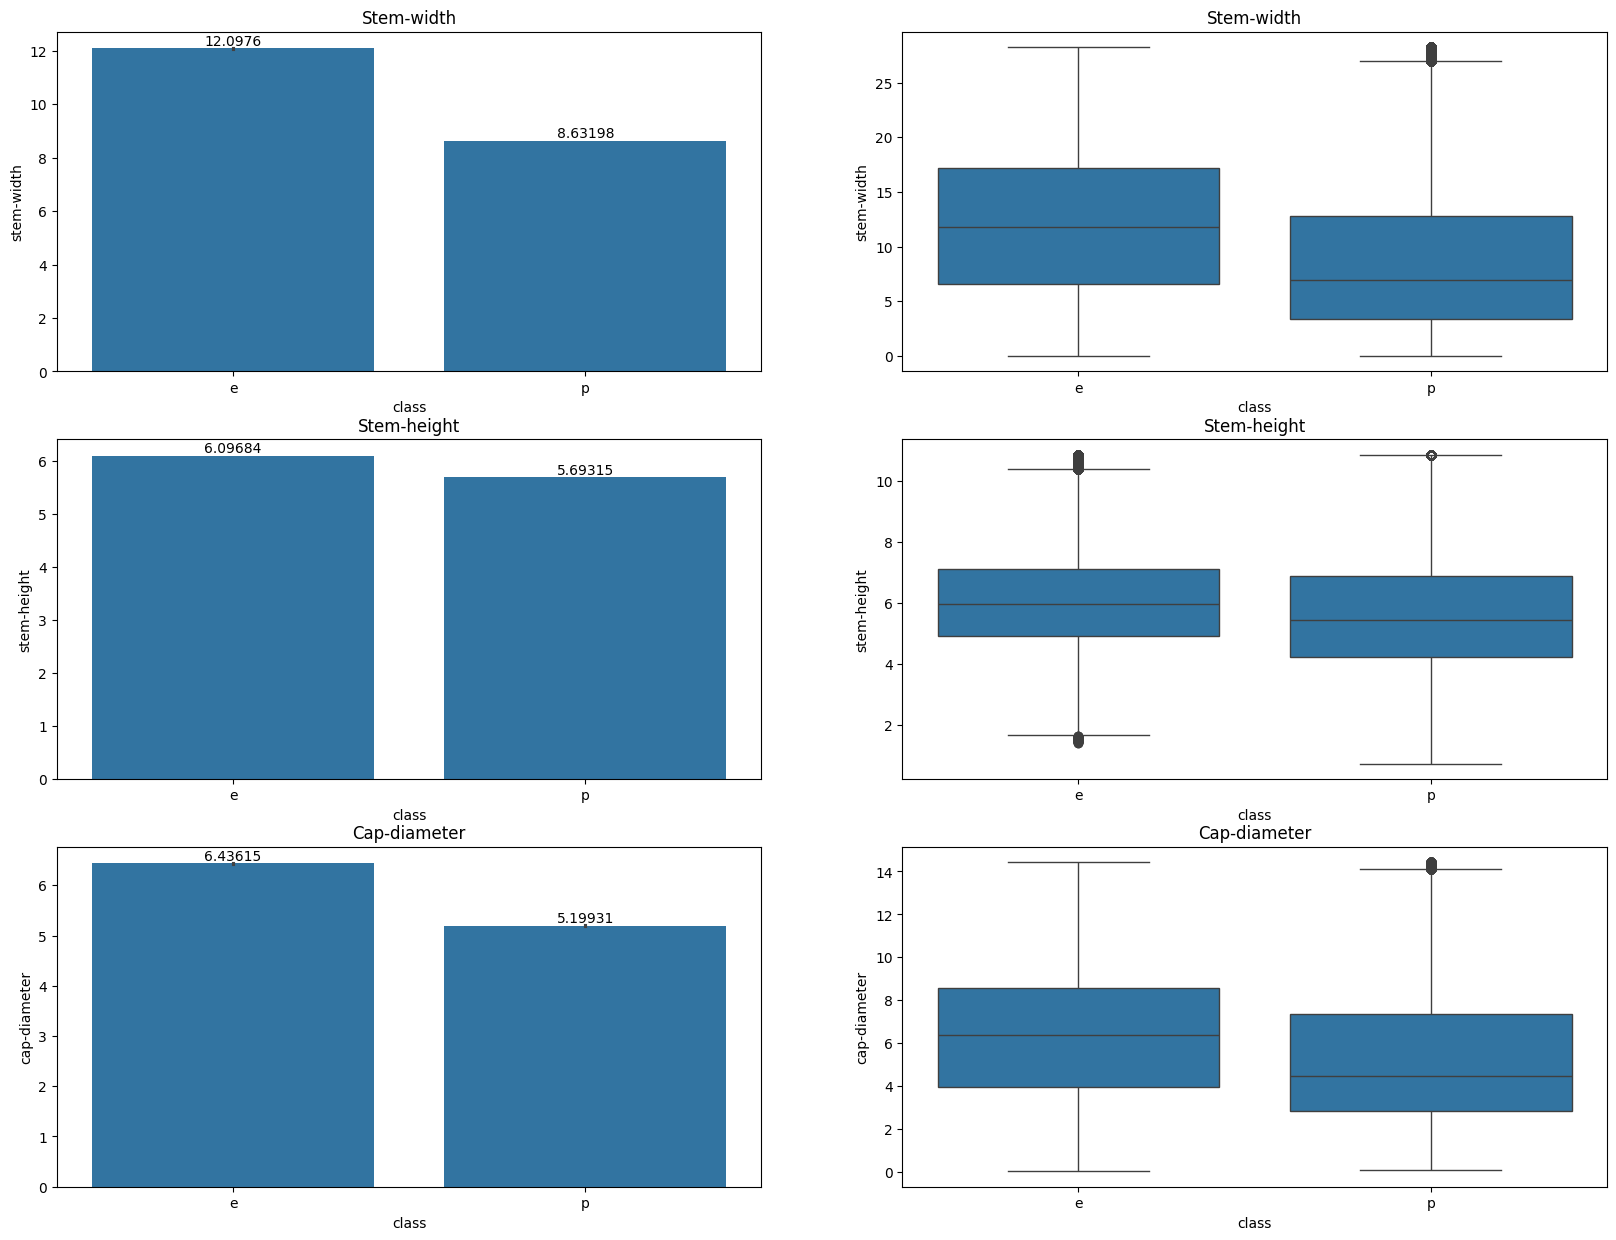

In [12]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
ax1 = sns.barplot(data=train_data, x='class', y='stem-width')
for p in ax1.containers:
    ax1.bar_label(p)
ax1.set_title("Stem-width")

plt.subplot(3, 2, 2)
ax2 = sns.boxplot(data=train_data, x='class', y='stem-width')
ax2.set_title("Stem-width")

plt.subplot(3, 2, 3)
ax3 = sns.barplot(data=train_data, x='class', y='stem-height')
ax3.set_title("Stem-height")
for p in ax3.containers:
    ax3.bar_label(p)
    
plt.subplot(3, 2, 4)
ax4 = sns.boxplot(data=train_data, x='class', y='stem-height')
ax4.set_title("Stem-height")
    
plt.subplot(3, 2, 5)
ax5 = sns.barplot(data=train_data, x='class', y='cap-diameter')
ax5.set_title("Cap-diameter")
for p in ax5.containers:
    ax5.bar_label(p)

plt.subplot(3, 2, 6)
ax6 = sns.boxplot(data=train_data, x='class', y='cap-diameter')
ax6.set_title("Cap-diameter")

## Categorical

In [13]:
categorical = train_data.select_dtypes(include=["object"]).columns[1:] # class 제외
categorical

Index(['season', 'does-bruise-or-bleed', 'cap-color', 'has-ring', 'stem-color', 'cap-shape', 'habitat', 'gill-color', 'ring-type', 'gill-attachment', 'cap-surface', 'gill-spacing', 'stem-surface'], dtype='object')

In [14]:
for column in categorical:
    value_ratio = train_data[column].value_counts() / train_data.shape[0]
    print(f"\nValue percents in '{column}':\n{value_ratio * 100}")


Value percents in 'season':
season
a    49.513899
u    37.010214
w     8.925053
s     4.550834
Name: count, dtype: float64

Value percents in 'does-bruise-or-bleed':
does-bruise-or-bleed
f           82.444284
t           17.551962
w            0.000449
c            0.000353
h            0.000289
a            0.000225
b            0.000225
x            0.000225
y            0.000225
k            0.000192
s            0.000192
e            0.000128
l            0.000128
p            0.000128
d            0.000128
g            0.000096
z            0.000096
o            0.000096
i            0.000064
n            0.000064
r            0.000032
has-ring     0.000032
3.43         0.000032
4.42         0.000032
2.9          0.000032
u            0.000032
Name: count, dtype: float64

Value percents in 'cap-color':
cap-color
n                       43.617773
y                       12.404037
w                       12.173522
g                        6.763834
e                        6.329595


In [15]:
for column in categorical:
    value_ratio = train_data[column].value_counts() / train_data.shape[0]
    index = value_ratio[value_ratio >= 0.01].index
    
    # train
    train_data.loc[~train_data[column].isin(index), column] = np.nan
    
    # train에서 추출된 value를 바탕으로 test에 존재하는 value 제거
    test_data.loc[~test_data[column].isin(index), column] = np.nan

In [16]:
for column in categorical:
    value_ratio = train_data[column].value_counts() / train_data.shape[0]
    print(f"\nValue percents in '{column}':\n{value_ratio * 100}")


Value percents in 'season':
season
a    49.513899
u    37.010214
w     8.925053
s     4.550834
Name: count, dtype: float64

Value percents in 'does-bruise-or-bleed':
does-bruise-or-bleed
f    82.444284
t    17.551962
Name: count, dtype: float64

Value percents in 'cap-color':
cap-color
n    43.617773
y    12.404037
w    12.173522
g     6.763834
e     6.329595
o     5.737894
p     2.946411
r     2.510022
u     2.347555
b     1.967086
k     1.921369
l     1.269127
Name: count, dtype: float64

Value percents in 'has-ring':
has-ring
f    75.998133
t    23.997279
Name: count, dtype: float64

Value percents in 'stem-color':
stem-color
w    38.391342
n    32.193831
y    11.997998
g     4.235525
o     3.578536
e     3.316485
u     2.150086
p     1.754603
k     1.080417
Name: count, dtype: float64

Value percents in 'cap-shape':
cap-shape
x    46.071586
f    21.695538
s    11.714868
b    10.223023
o     3.491720
p     3.431790
c     3.353283
Name: count, dtype: float64

Value percents in 'habi

In [17]:
for column in categorical:
    value_ratio = test_data[column].value_counts() / test_data.shape[0]
    print(f"\nValue percents in '{column}':\n{value_ratio * 100}")


Value percents in 'season':
season
a    49.523716
u    36.972103
w     8.949866
s     4.554314
Name: count, dtype: float64

Value percents in 'does-bruise-or-bleed':
does-bruise-or-bleed
f    82.468320
t    17.528071
Name: count, dtype: float64

Value percents in 'cap-color':
cap-color
n    43.518896
y    12.467107
w    12.215996
g     6.770137
e     6.329465
o     5.763526
p     2.944517
r     2.492055
u     2.351581
b     1.962979
k     1.906433
l     1.263785
Name: count, dtype: float64

Value percents in 'has-ring':
has-ring
f    75.944145
t    24.050417
Name: count, dtype: float64

Value percents in 'stem-color':
stem-color
w    38.372416
n    32.154359
y    12.037793
g     4.244636
o     3.613826
e     3.311126
u     2.155187
p     1.749597
k     1.067198
Name: count, dtype: float64

Value percents in 'cap-shape':
cap-shape
x    46.100366
f    21.769386
s    11.679606
b    10.196471
o     3.463583
p     3.431340
c     3.341540
Name: count, dtype: float64

Value percents in 'habi

In [18]:
# 중간 저장이 필요할 때만

# train_data.to_csv(DATA / "train_outlier_preprocessing_1per_under+nan_80per_under.csv", index=False)
# test_data.to_csv(DATA / "test_outlier_preprocessing_1per_under+nan_80per_under.csv", index=False)

## Simple Imputation
- knn impute

In [19]:
features = train_data.columns[1:]

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 17 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   stem-height           float64
 2   stem-width            float64
 3   season                object 
 4   cap-diameter          float64
 5   does-bruise-or-bleed  object 
 6   cap-color             object 
 7   has-ring              object 
 8   stem-color            object 
 9   cap-shape             object 
 10  habitat               object 
 11  gill-color            object 
 12  ring-type             object 
 13  gill-attachment       object 
 14  cap-surface           object 
 15  gill-spacing          object 
 16  stem-surface          object 
dtypes: float64(3), object(14)
memory usage: 404.3+ MB


In [21]:
train_data[numerical] = train_data[numerical].astype(np.float32)

In [29]:
train_data["missing_value"] = np.where(train_data.isna().any(axis=1), 1, 0)
test_data["missing_value"] = np.where(test_data.isna().any(axis=1), 1, 0)

In [30]:
# Numerical Imputation(mean)

train_mean = train_data[numerical].mean()

train_data[numerical] = train_data[numerical].fillna(train_mean)
test_data[numerical] = test_data[numerical].fillna(train_mean)

In [31]:
train_data[numerical].isna().sum()

stem-height     0
stem-width      0
cap-diameter    0
dtype: int64

In [32]:
test_data[numerical].isna().sum()

stem-height     0
stem-width      0
cap-diameter    0
dtype: int64

In [33]:
# Categorical Imputation(mode)

train_data[categorical].isna().sum()

season                        0
does-bruise-or-bleed        117
cap-color                   367
has-ring                    143
stem-color                40557
cap-shape                   567
habitat                   41466
gill-color                  492
ring-type                133272
gill-attachment          524437
cap-surface              671625
gill-spacing            1258579
stem-surface            2010052
dtype: int64

In [34]:
missing_ratio = train_data[categorical].isna().mean()
mode_index = missing_ratio[(0 < missing_ratio) & (missing_ratio <= 0.01)]
mode_index

does-bruise-or-bleed    0.000038
cap-color               0.000118
has-ring                0.000046
cap-shape               0.000182
gill-color              0.000158
dtype: float64

In [35]:
# 결측 비율 계산
missing_ratio = train_data[categorical].isna().mean()

# 결측 비율이 1% 이하이면 최빈값으로 결측치를 채우기 이상이면 Unknown으로 대체함
mode_index = missing_ratio[(0 < missing_ratio) & (missing_ratio <= 0.01)].index
unknown_index = missing_ratio[missing_ratio > 0.01].index

# mode로 결측치 채우기
for column in mode_index:
    mode = train_data[column].mode()[0]
    train_data[column] = train_data[column].fillna(mode)
    test_data[column] = test_data[column].fillna(mode)

# 결측치 Unknown으로 바꾸기
for column in unknown_index:
    fill_value = 'Unknown'
    train_data[column] = train_data[column].fillna(fill_value)
    test_data[column] = test_data[column].fillna(fill_value)

In [36]:
train_data.isna().sum()

class                   0
stem-height             0
stem-width              0
season                  0
cap-diameter            0
does-bruise-or-bleed    0
cap-color               0
has-ring                0
stem-color              0
cap-shape               0
habitat                 0
gill-color              0
ring-type               0
gill-attachment         0
cap-surface             0
gill-spacing            0
stem-surface            0
missing_value           0
dtype: int64

In [37]:
test_data.isna().sum()

stem-height             0
stem-width              0
season                  0
cap-diameter            0
does-bruise-or-bleed    0
cap-color               0
has-ring                0
stem-color              0
cap-shape               0
habitat                 0
gill-color              0
ring-type               0
gill-attachment         0
cap-surface             0
gill-spacing            0
stem-surface            0
missing_value           0
dtype: int64

In [38]:
train_data.to_csv(DATA / "train_simple_imputation_01.csv", index=False)
test_data.to_csv(DATA / "test_simple_imputation_01.csv", index=False)